### Setup

In [1]:
import pyedflib
import pandas as pd
from lxml import etree

### Functions

In [2]:
### EDF Files

def load_psg(path):
    edf_reader = pyedflib.EdfReader(path)

    signal_labels = edf_reader.getSignalLabels()

    signals = {}
    frequencies = {}
    for i in range(edf_reader.signals_in_file):
        signals[signal_labels[i]] = pd.Series(edf_reader.readSignal(i))
        frequencies[signal_labels[i]] = edf_reader.getSampleFrequency(i)
    
    edf_reader.close()
    return signals, frequencies

### R-Point CSV Files

def load_rpoint(path):
    df = pd.read_csv(path)
    return df

### NSRR Annotation Files

def to_obj(event):
    obj = {}
    for child in event:
        #if not child.tag == 'EventType':
            obj[child.tag] = child.text
    return obj

def load_annotations(path):
    tree = etree.parse(path)
    root = tree.getroot()
    all_events = root.xpath("//ScoredEvent")

    recording_start = []
    events_respiratory = []
    events_arousals = []
    events_limb_movements = []
    events_stages = []

    event_categories = {
        None: recording_start,
        'Respiratory|Respiratory': events_respiratory,
        'Arousals|Arousals': events_arousals,
        'Limb Movement|Limb Movement': events_limb_movements,
        'Stages|Stages': events_stages,
        'Technician Notes': [], # TODO what is this?
        'Electrocardiogram|Electrocardiogram': [] # TODO again
    }

    for event in all_events:
        for child in event:
            if child.tag == 'EventType':
                event_categories[child.text].append(to_obj(event))
    
    recording_start = recording_start[0]['ClockTime']
    return recording_start, \
        events_respiratory, \
        events_arousals, \
        pd.DataFrame(events_limb_movements), \
        events_stages


### Data

In [3]:
MAIN_DIR = '/vol/sleepstudy/datasets/mesa/polysomnography/'

PSG

['EKG', 'EOG-L', 'EOG-R', 'EMG', 'EEG1', 'EEG2', 'EEG3', 'Pres', 'Flow', 'Snore', 'Thor', 'Abdo', 'Leg', 'Therm', 'Pos', 'EKG_Off', 'EOG-L_Off', 'EOG-R_Off', 'EMG_Off', 'EEG1_Off', 'EEG2_Off', 'EEG3_Off', 'Pleth', 'OxStatus', 'SpO2', 'HR', 'DHR']


<Axes: >

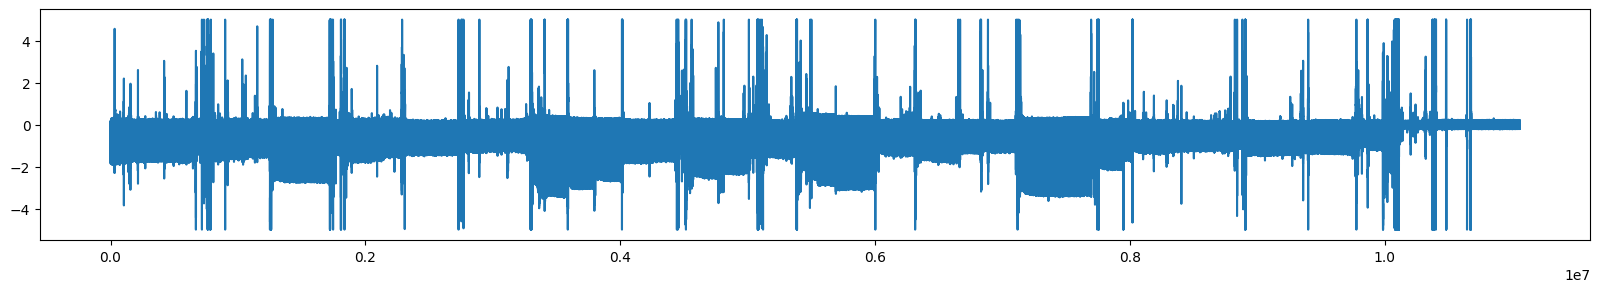

In [4]:
mesa0001_psg, mesa0001_psg_freqs = load_psg(MAIN_DIR + 'edfs/mesa-sleep-0001.edf')
print(list(mesa0001_psg.keys()))
mesa0001_psg['EKG'].plot(figsize=(20, 3))

In [11]:
df_signals, df_frequencies, df_num_vals = [], [], []
for signal in list(mesa0001_psg.keys()):
    df_signals.append(signal)
    df_frequencies.append(mesa0001_psg_freqs[signal])
    df_num_vals.append(len(mesa0001_psg[signal]))
df = pd.DataFrame({'Signal': df_signals, 'Frequency': df_frequencies, '# Values': df_num_vals})
df.set_index('Signal')

,Frequency,# Values
Signal,,
EKG,256.0,11058944
EOG-L,256.0,11058944
EOG-R,256.0,11058944
EMG,256.0,11058944
EEG1,256.0,11058944
EEG2,256.0,11058944
EEG3,256.0,11058944
Pres,32.0,1382368
Flow,32.0,1382368


R-Points

In [5]:
mesa0001_rpoints = load_rpoint(MAIN_DIR + 'annotations-rpoints/mesa-sleep-0001-rpoint.csv')
mesa0001_rpoints.head()

,epoch,RPoint,Start,End,STLevel1,STSlope1,STLevel2,STSlope2,Manual,Type,Class,PPoint,PStart,PEnd,TPoint,TStart,TEnd,TemplateID,seconds,stage
0,1,149,144,155,220,-1292,9866,0,0,1,NaN,NaN,NaN,NaN,215,NaN,NaN,0,0.582031,0
1,1,332,325,346,214,1998,346,0,0,1,NaN,NaN,NaN,NaN,393,NaN,NaN,0,1.296875,0
2,1,533,502,546,-931,1783,546,0,0,1,NaN,NaN,NaN,NaN,595,NaN,NaN,0,2.082031,0
3,1,733,723,746,24,1077,746,0,0,1,NaN,NaN,NaN,NaN,793,NaN,NaN,0,2.863281,0
4,1,930,920,937,216,-865,937,0,0,1,NaN,NaN,NaN,NaN,990,NaN,NaN,0,3.632812,0


NSRR Annotations

<Axes: >

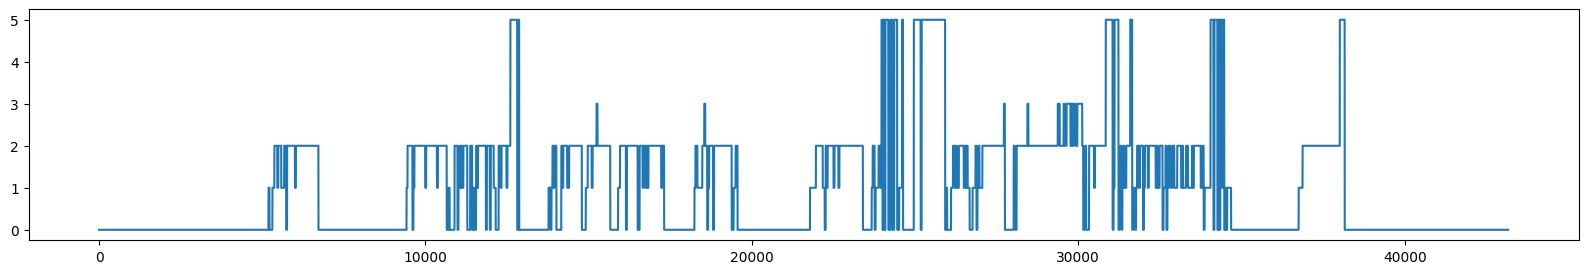

In [17]:
start, er, ea, el, stages = load_annotations(MAIN_DIR + 'annotations-events-nsrr/mesa-sleep-0001-nsrr.xml')

stage_list = []
for _, state_event in stages.iterrows():
    stage = int(state_event.loc['EventConcept'].split('|')[1])
    stage_list += [stage]*int(state_event.loc['Duration'].split('.')[0])
pd.Series(stage_list).plot(figsize=(20, 3))

In [30]:
stages

[{'EventType': 'Stages|Stages',
  'EventConcept': 'Wake|0',
  'Start': '0.0',
  'Duration': '5190.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5190.0',
  'Duration': '30.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Wake|0',
  'Start': '5220.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5310.0',
  'Duration': '60.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5370.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5460.0',
  'Duration': '30.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5490.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5580.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5670.0',
  'Duration': '60.0'},
 {

In [25]:
_, _, _, _, stages = load_annotations(MAIN_DIR + 'annotations-events-nsrr/mesa-sleep-0001-nsrr.xml')
all_keys = []
for event in stages:
    all_keys += list(event.keys())
print(Counter(all_keys))

Counter({'EventType': 259, 'EventConcept': 259, 'Start': 259, 'Duration': 259})


In [26]:
stages

[{'EventType': 'Stages|Stages',
  'EventConcept': 'Wake|0',
  'Start': '0.0',
  'Duration': '5190.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5190.0',
  'Duration': '30.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Wake|0',
  'Start': '5220.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5310.0',
  'Duration': '60.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5370.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5460.0',
  'Duration': '30.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5490.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 1 sleep|1',
  'Start': '5580.0',
  'Duration': '90.0'},
 {'EventType': 'Stages|Stages',
  'EventConcept': 'Stage 2 sleep|2',
  'Start': '5670.0',
  'Duration': '60.0'},
 {

In [21]:
all_keys = []
all_EvTy = []
all_EvCo = []
all_Sta = []
all_Dur = []
all_Loc = []
for event in ea:
    all_keys += list(event.keys())
    all_EvTy.append(event['EventType'])
    all_EvCo.append(event['EventConcept'])
    all_Sta.append(event['Start'])
    all_Dur.append(event['Duration'])
    all_Loc.append(event['SignalLocation'])
print(Counter(all_keys))
print(Counter(all_EvTy))
print(Counter(all_EvCo))
print(Counter(all_Sta))
print(Counter(all_Dur))
print(Counter(all_Loc))

Counter({'EventType': 197, 'EventConcept': 197, 'Start': 197, 'Duration': 197, 'SignalLocation': 197})
Counter({'Arousals|Arousals': 197})
Counter({'Arousal|Arousal ()': 197})
Counter({'5220.5': 1, '5340.1': 1, '5462.8': 1, '5503': 1, '5563.3': 1, '5589.1': 1, '5610.2': 1, '5635.5': 1, '5662.7': 1, '5683.1': 1, '5713.4': 1, '5752.2': 1, '5878.6': 1, '5998.8': 1, '6082': 1, '6426.8': 1, '6708.4': 1, '9606.2': 1, '9991.5': 1, '10034': 1, '10244.5': 1, '10341': 1, '10659.5': 1, '10730': 1, '10745.1': 1, '10980.6': 1, '11043': 1, '11072.3': 1, '11120.3': 1, '11182.1': 1, '11289.7': 1, '11386.4': 1, '11430.8': 1, '11463.4': 1, '11499.4': 1, '11578.8': 1, '11742.8': 1, '11806.3': 1, '11859.5': 1, '11925.7': 1, '11975.4': 1, '12090.4': 1, '12142.9': 1, '12296.8': 1, '12490.2': 1, '12528.2': 1, '12616.1': 1, '12684.7': 1, '12737.5': 1, '12766': 1, '12804.5': 1, '12863.3': 1, '13791.7': 1, '13839.6': 1, '13910.5': 1, '13999.3': 1, '14191': 1, '14338.5': 1, '14801.5': 1, '14915.9': 1, '14943.3':

In [22]:
all_keys = []
for event in er:
    all_keys += list(event.keys())
print(Counter(all_keys))

Counter({'EventType': 649, 'EventConcept': 649, 'Start': 649, 'Duration': 649, 'SignalLocation': 649, 'SpO2Nadir': 371, 'SpO2Baseline': 371})


In [7]:
print(', '.join(list(mesa0001_psg.keys())))
print(len(mesa0001_psg.keys()))

EKG, EOG-L, EOG-R, EMG, EEG1, EEG2, EEG3, Pres, Flow, Snore, Thor, Abdo, Leg, Therm, Pos, EKG_Off, EOG-L_Off, EOG-R_Off, EMG_Off, EEG1_Off, EEG2_Off, EEG3_Off, Pleth, OxStatus, SpO2, HR, DHR
27


In [8]:
all_keys = []
for ev in er:
    all_keys += list(ev.keys())
print(all_keys)

['EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Start', 'Duration', 'SignalLocation', 'SpO2Nadir', 'SpO2Baseline', 'EventConcept', 'Sta

In [9]:
from collections import Counter
Counter(all_keys)

Counter({'EventConcept': 649,
         'Start': 649,
         'Duration': 649,
         'SignalLocation': 649,
         'SpO2Nadir': 371,
         'SpO2Baseline': 371})

In [10]:
er[0]

{'EventConcept': 'SpO2 desaturation|SpO2 desaturation',
 'Start': '148',
 'Duration': '31',
 'SignalLocation': 'SpO2',
 'SpO2Nadir': '96',
 'SpO2Baseline': '98.0'}

In [11]:
all_concepts = []
for ev in er:
    all_concepts.append(ev['EventConcept'])
Counter(all_concepts)

Counter({'SpO2 desaturation|SpO2 desaturation': 371,
         'Unsure|Unsure': 157,
         'Hypopnea|Hypopnea': 85,
         'Obstructive apnea|Obstructive Apnea': 19,
         'SpO2 artifact|SpO2 artifact': 17})

In [ ]:
_, er2, ea2, _, _ = load_annotations(MAIN_DIR + 'annotations-events-nsrr/mesa-sleep-0010-nsrr.xml')

all_keys_er2 = []
for ev in er2:
    all_keys_er2 += list(ev.keys())
print('Keys er:', Counter(all_keys_er2))

all_keys_ea2 = []
for ev in ea2:
    all_keys_ea2 += list(ev.keys())
print('Keys ea:', Counter(all_keys_ea2))

all_concepts_er2 = []
for ev in er2:
    all_concepts_er2.append(ev['EventConcept'])
print('Concepts er:', Counter(all_concepts_er2))

all_concepts_ea2 = []
for ev in ea2:
    all_concepts_ea2.append(ev['EventConcept'])
print('Concepts er:', Counter(all_concepts_ea2))

Keys er: Counter({'EventConcept': 323, 'Start': 323, 'Duration': 323, 'SignalLocation': 323, 'SpO2Nadir': 201, 'SpO2Baseline': 201})
Keys ea: Counter({'EventConcept': 97, 'Start': 97, 'Duration': 97, 'SignalLocation': 97})
Concepts er: Counter({'SpO2 desaturation|SpO2 desaturation': 201, 'Hypopnea|Hypopnea': 60, 'Unsure|Unsure': 41, 'Obstructive apnea|Obstructive Apnea': 11, 'SpO2 artifact|SpO2 artifact': 10})
Concepts er: Counter({'Arousal|Arousal ()': 97})


In [13]:
import os
from tqdm import tqdm

In [16]:
all_annots = os.listdir('/vol/sleepstudy/datasets/mesa/polysomnography/annotations-events-nsrr/')
all_concepts_annot = []
for annot in tqdm(all_annots):
    _, er, _, _, _ = load_annotations(MAIN_DIR + f'annotations-events-nsrr/{annot}')
    for ev in er2:
        all_concepts_annot.append(ev['EventConcept'])

Counter(all_concepts_annot)

  5%|▌         | 111/2056 [00:01<00:22, 87.59it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5041.8', 'Duration': '17.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5145.7', 'Duration': '4.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5239.8', 'Duration': '3', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5273.3', 'Duration': '6.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5325.6', 'Duration': '19.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5734.6', 'Duration': '5.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5826.4', 'Duration': '7.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Tech

 29%|██▊       | 586/2056 [00:06<00:18, 81.18it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5401.7', 'Duration': '16.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5456.5', 'Duration': '5.1', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5481', 'Duration': '5.6', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5506.5', 'Duration': '5.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5540.6', 'Duration': '3', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5568.6', 'Duration': '8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5647', 'Duration': '3', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician No

 31%|███▏      | 644/2056 [00:07<00:16, 84.20it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '33201.9', 'Duration': '0', 'Notes': 'Arousal (ARO Limb)'}]


 40%|███▉      | 819/2056 [00:09<00:14, 87.56it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '2950.3', 'Duration': '11.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '2994.2', 'Duration': '5.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3044.7', 'Duration': '10.4', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3065.6', 'Duration': '13.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3104.1', 'Duration': '15.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3175.8', 'Duration': '4.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3225.8', 'Duration': '13', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'T

 56%|█████▌    | 1153/2056 [00:13<00:09, 95.46it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4324.7', 'Duration': '6.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4351.3', 'Duration': '21.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4457.2', 'Duration': '18.6', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4653.7', 'Duration': '5.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4707.4', 'Duration': '7.4', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4764.5', 'Duration': '3.4', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4973.8', 'Duration': '22.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'T

 72%|███████▏  | 1471/2056 [00:16<00:06, 93.29it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '1712.2', 'Duration': '5.1', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '1728.9', 'Duration': '5.7', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4233.1', 'Duration': '7.5', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4269.7', 'Duration': '19.7', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4866.2', 'Duration': '19.3', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '4965.7', 'Duration': '9.6', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5339', 'Duration': '17.8', 'Notes': 'Arousal (AASM)'}, {'EventType': 'Technician Notes', 'EventConcep

 75%|███████▌  | 1549/2056 [00:17<00:06, 72.50it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '32909.6', 'Duration': '3', 'Notes': 'Arousal (ARO Limb)'}]


 78%|███████▊  | 1609/2056 [00:18<00:05, 88.65it/s]

[{'EventType': 'Electrocardiogram|Electrocardiogram', 'EventConcept': 'Narrow complex tachycardia|Narrow Complex Tachycardia', 'Start': '19079.6', 'Duration': '0', 'SignalLocation': 'EKG'}]


 79%|███████▉  | 1629/2056 [00:18<00:04, 88.03it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5811', 'Duration': '10', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5885.6', 'Duration': '14.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5914.3', 'Duration': '4.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5950.7', 'Duration': '3.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5990.4', 'Duration': '3.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '6042.9', 'Duration': '5.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '6069.3', 'Duration': '5.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Techni

 84%|████████▍ | 1722/2056 [00:19<00:03, 96.65it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '203.6', 'Duration': '6', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '250.5', 'Duration': '18.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '435.7', 'Duration': '7.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '860.8', 'Duration': '9.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '1498.9', 'Duration': '7.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '1520.5', 'Duration': '6.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '1555', 'Duration': '4.7', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician 

 91%|█████████ | 1867/2056 [00:21<00:02, 90.40it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '14619.2', 'Duration': '11.2', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '22710.4', 'Duration': '0', 'Notes': 'Arousal (ARO Limb)'}]
[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5570.3', 'Duration': '4.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '7609.8', 'Duration': '24.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '7668.2', 'Duration': '12.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '7700.5', 'Duration': '3.5', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '8944.4', 'Duration': '18.9', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 

 99%|█████████▊| 2029/2056 [00:22<00:00, 84.99it/s]

[{'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '3764.3', 'Duration': '8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5150.9', 'Duration': '7.1', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5410', 'Duration': '29.6', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '5550.2', 'Duration': '14.8', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '7608.7', 'Duration': '11.1', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '18879.2', 'Duration': '15', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Technician Notes', 'EventConcept': 'Technician Notes', 'Start': '20160.4', 'Duration': '11.4', 'Notes': 'Arousal (ARO Limb)'}, {'EventType': 'Tec

100%|██████████| 2056/2056 [00:23<00:00, 88.92it/s]


Counter({'SpO2 desaturation|SpO2 desaturation': 413256,
         'Hypopnea|Hypopnea': 123360,
         'Unsure|Unsure': 84296,
         'Obstructive apnea|Obstructive Apnea': 22616,
         'SpO2 artifact|SpO2 artifact': 20560})